
# 04 – Calibration des modèles et mesures de risque (VaR / CVaR)

Ce notebook regroupe :
- la **calibration** des paramètres sur des données de marché / simulées
  (méthode des moments, maximum de vraisemblance, calibration sur prix d'options) ;
- le calcul de **mesures de risque** (VaR, CVaR) à partir de séries de prix simulées
  ou historiques.


In [1]:

import pathlib, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NOTEBOOK_DIR = pathlib.Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "src"))

from calibration.moments import *
from calibration.likelihood import log_likelihood   # idem
from calibration.optimization import calibrate_model  # idem
from risk.var import var_cvar_from_prices



## 1. Chargement ou simulation d'une série de prix

On part d'une série de prix (historique ou simulée) pour calibrer un modèle simple
(par exemple GBM ou Variance Gamma).


In [ ]:
data_dir = PROJECT_ROOT / "data"
sample_csv = data_dir / "market_data_clean.csv" 

if sample_csv.exists():
    print("Utilisation des données :", sample_csv)
    df = pd.read_csv(sample_csv)
    
    price_col_candidates = [c for c in df.columns if c.lower() in ('close', 'price', 'adj_close')]
    
    if price_col_candidates:
        price_col = price_col_candidates[0]
        
        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
        
        df.dropna(subset=[price_col], inplace=True)
        
        prices = df[price_col].astype(float).values
    else:
        raise RuntimeError("Impossible d'identifier une colonne de prix dans df.")
        
else:
    print("Aucune donnée trouvée. Génération de prix synthétiques (GBM) pour la démonstration.")
    
    
log_returns = np.diff(np.log(prices))

print("Nb de rendements :", len(log_returns))
print("Moyenne :", np.mean(log_returns))
print("Volatilité (std) :", np.std(log_returns))

Utilisation des données : /home/hugo/Bureau/Github/BasicQuantitativeAlgorithms/data/market_data_clean.csv
Nb de rendements : 755
Moyenne : 0.0007534747223390814
Volatilité (std) : 0.023239828303422173



## 2. Calibration par moments

On illustre l'idée : faire coïncider les moments empiriques et théoriques.


In [9]:

# Exemple fictif : on suppose que moments_objective(theta, data) renvoie
# une fonction de coût à minimiser, ou bien directement la valeur de l'objectif.

theta0 = np.array([0.05, 0.2])
cost0 = gbm_moments_objective(theta0, log_returns)
theta_hat, res = calibrate_model(lambda th: gbm_moments_objective(th, log_returns), theta0)

print("Coût (moments) au point initial :", cost0)



print("Paramètres calibrés (méthode des moments) :", theta_hat)


Coût (moments) au point initial : 0.002412443768048227
Paramètres calibrés (méthode des moments) : [0.00102754 0.02320303]



## 3. Maximum de vraisemblance

Si l'on connaît une densité $f_\theta$ pour les rendements,
on maximise la log-vraisemblance
$$ \ell(\theta) = \sum_{t} \log f_\theta(R_t). $$


In [ ]:

theta0 = np.array([0.05, 0.2])  # initial guess

ll0 = log_likelihood(theta0, log_returns)
print("Log-vraisemblance au point initial :", ll0)

theta_hat_mle = calibrate_model(
    objective=lambda th: -log_likelihood(th, log_returns),
    theta0=theta0,
    method="nelder-mead",
)

print("Paramètres calibrés (MLE) :", theta_hat_mle)




Log-vraisemblance au point initial : 508.1574826982928
Paramètres calibrés (MLE) : (array([0.00102522, 0.02324285]),        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1768.9266327482032
             x: [ 1.025e-03  2.324e-02]
           nit: 44
          nfev: 85
 final_simplex: (array([[ 1.025e-03,  2.324e-02],
                       [ 1.018e-03,  2.324e-02],
                       [ 1.029e-03,  2.323e-02]]), array([-1.769e+03, -1.769e+03, -1.769e+03])))



## 4. Mesures de risque : VaR et CVaR

À partir des prix, on calcule VaR et CVaR empiriques.


In [11]:

alpha = 0.99
horizon = 1

var, cvar = var_cvar_from_prices(prices, horizon=horizon, alpha=alpha)
print(f"VaR (alpha={alpha})  :", var)
print(f"CVaR (alpha={alpha}) :", cvar)


VaR (alpha=0.99)  : -0.059176477921594146
CVaR (alpha=0.99) : -0.083857362027278


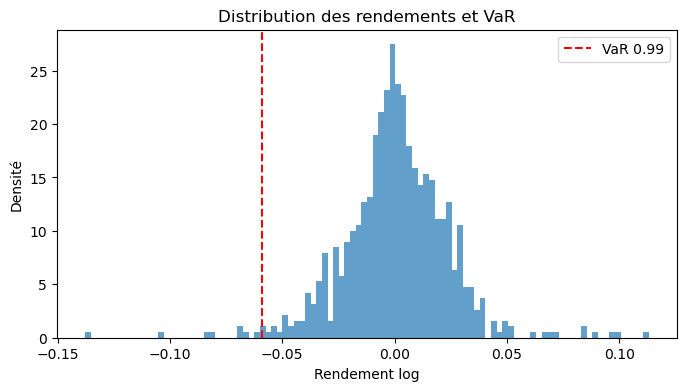

In [12]:

# Visualisation de la distribution des rendements avec le seuil de VaR
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))
plt.hist(np.diff(np.log(prices)), bins=100, density=True, alpha=0.7)
plt.axvline(var, color="red", linestyle="--", label=f"VaR {alpha:.2f}")
plt.title("Distribution des rendements et VaR")
plt.xlabel("Rendement log")
plt.ylabel("Densité")
plt.legend()
plt.show()



### Axes d'analyse

- Comparer les paramètres calibrés (moments vs MLE) et leur impact sur
  la forme de la distribution simulée.
- Simuler des trajectoires avec les paramètres calibrés et recalculer VaR/CVaR.
- Étudier la stabilité de la VaR en fonction de la fenêtre historique et du niveau $\alpha$.
